## Sentiment Analysis of Tweets 

Wachira James

Tim Musungu

Vivian Kwamboka

Calvin Mutua

Hashim Ibrahim

## Project Executive Summary
***

This project applies Natural Language Processing (NLP) and machine learning techniques to analyze customer sentiment from textual data. The objective is to extract actionable insights that can help businesses understand customer feedback, identify areas of dissatisfaction, and improve service delivery.

After preprocessing raw text data using techniques like tokenization, TF-IDF vectorization, and class balancing with SMOTE, multiple classification models were trained and evaluated, including Random Forests, XGBoost, and Naive Bayes variants. The best-performing model, based on F1-score and accuracy, was the Tuned Random Forest, achieving 66.89% accuracy and 53.65% F1-score, followed closely by XGBoost with SMOTE and Multinomial Naive Bayes.

The analysis revealed that a significant proportion of reviews are negative, indicating a need for product or service improvements. The most important features influencing model predictions include terms associated with service issues, product dissatisfaction, and delivery delays. These insights offer a data-driven foundation for improving customer experience, prioritizing support areas, and enhancing overall satisfaction.

### 2. Project Introduction

In today's fast-paced digital world, businesses are constantly exposed to public feedback on social media platforms like Twitter. This feedback contains valuable insights into customer sentiment, perceptions of products or services, and overall brand reputation. However, the unstructured and high-volume nature of tweets makes manual analysis impractical.

### 3. Project Objectives
The goal of this project is to develop a machine learning-based sentiment analysis system that automatically classifies tweets related to different product categories into sentiment classes: **Negative**, **Neutral**, or **Positive**. This enables stakeholders to:

- Monitor public sentiment in real time
- Identify product-specific issues or praise
- Improve customer service responsiveness

By transforming raw tweet data into structured, actionable insights, the business can respond proactively to customer needs and protect its brand image.


### 4. Business Understanding

This project will address several real-world business challenges that affect customer experience, brand reputation, and operational efficiency. Below are the key problems tackled:

1. **Customer Sentiment Understanding**
   - TO Automatically classifies tweets into _Negative_, _Neutral_, and _Positive_ categories, enabling the business to gauge public opinion at scale.

2. **Brand Reputation Monitoring**
   - To Identify early signs of dissatisfaction or crisis by tracking shifts in sentiment, allowing the company to take proactive measures.

3. **Product-Specific Feedback Insights**
   - To try and Incorporate `product_category` into the model, enabling teams to analyze which product lines receive the most praise or complaints.

### 5. Data Understanding
The dataset used in this project comes from CrowdFlower via data.world. It is a collection of **~9000** tweets labeled with sentiment categories about Apple and Google products. It includes the following fields:

- `text`: The tweet content (raw text)

- `product_cat`: The product category (described the product the tweet was referring to)

- `label`: The sentiment of the tweet (originally a text label, later mapped to numeric values)

Our key metrics for model performance are:

- **Accuracy** (cross-validated)
- **F1 Score** (weighted)
- **ROC_AUC Score**

### 6. Data Preparation

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,f1_score, roc_auc_score
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

import os
os.environ['LOKY_MAX_CPU_COUNT'] = '2'



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


This cell imports essential libraries required for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), 
and text preprocessing (re for regex, string). These form the foundation for the NLP and analysis tasks that follow.


### 6.1. Data Cleaning and Text Preprocessing

In [2]:
# Read in the data
tweets = pd.read_csv('data/tweets.csv', encoding = 'iso-8859-1')
tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


This cell loads the dataset from a CSV file into a pandas DataFrame. The dataset contains airline tweets, which will be 
analyzed for sentiment. A preview of the data is shown using `.head()` to verify it loaded correctly.


In [3]:
# Rename columns
tweets.columns = ['text', 'product_cat', 'label']


- We change the `label` column values using this mapping:
    - 'Negative emotion': 0 (**Negative**), 
    - 'No emotion toward brand or product': 1 (**Neutral**), 
    - 'Positive emotion': 2 (**Positive**), 
    - "I can't tell": 3 (to be dropped)

In [4]:
# Map labels to numerical values
tweets['label'] = tweets['label'].map({'Negative emotion': 0, 'No emotion toward brand or product': 1, 'Positive emotion': 2, "I can't tell": 3})

# Filter out 'I can't tell' label
tweets = tweets[tweets['label'] != 3]

tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         8936 non-null   object
 1   product_cat  3282 non-null   object
 2   label        8937 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 279.3+ KB


Thi above cell gives a summary of the dataset, checking for null values in each column, where the `product_cat` column has a lot null values. It helps identify missing data that 
might need to be handled during preprocessing.



In [5]:
# Drop unecessary columns
tweets.drop(columns=['product_cat'], inplace=True)

# Drop null values
tweets.dropna(inplace=True)

# Drop duplicates
tweets.drop_duplicates(inplace=True)

tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8914 non-null   object
 1   label   8914 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 208.9+ KB


- We create a function which preprocesses the text by removing punctuation, digits, converting to lowercase, and removing extra whitespace.
 
- It's crucial for cleaning text before vectorization and model training.

In [6]:
# Convert NLTK POS tags to Wordnet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun


stop_words = set(stopwords.words('english'))

# Preprocess the text data
def pre_proc(text):
    # Remove conversions made during scraping
    text = re.sub(r'{link}', '', text)
    text = re.sub(r'\[video\]', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove Non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Substitute '/' with 'or'
    text = re.sub(r'/', ' or ', text)
    
    # Remove RT (retweet)
    text = re.sub(r'\b_*\brt\b', '', text, flags=re.IGNORECASE)
   
    text = str.lower(text) # Convert to lowercase
    
    # Tokenize the text using TweetTokenizer
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # POS tagging and lemmatization
    lemmatizer = WordNetLemmatizer()
    pos_tags = pos_tag(tokens)

    tokens = [
        lemmatizer.lemmatize(token, get_wordnet_pos(pos)) 
        for token, pos in pos_tags]

    return tokens

# Apply the pre_proc function to the 'text' column
tweets['clean_text'] = tweets['text'].astype(str).apply(pre_proc)

# Create a document feature by joining lemmatized tokens
tweets['document'] = tweets['clean_text'].apply(lambda tokens: ' '.join(tokens))

tweets[['text', 'clean_text', 'document']].head()

,text,clean_text,document
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,"[3g, iphone, 3, hr, tweet, dead, need, upgrade...",3g iphone 3 hr tweet dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,"[know, awesome, ipadiphone, app, youll, likely...",know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,"[wait, 2, also, sale]",wait 2 also sale
3,@sxsw I hope this year's festival isn't as cra...,"[hope, year, festival, isnt, crashy, year, iph...",hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim oreil...


### 6.2. Feature Engineering

In [7]:
# Add feature columns for text analysis
tweets['chars'] = tweets['text'].apply(lambda x: len(x))
tweets['words'] = tweets['text'].apply(lambda x: len(nltk.word_tokenize(x)))
tweets['sentences'] = tweets['text'].apply(lambda x: len(nltk.sent_tokenize(x)))


In [8]:
# Define a function that classifies a tweet as either referring to Apple or Google products
# Returns a string representing the relevant product category - either Apple or Google

def identify_product(tweet):
    tweet_check = tweet.lower()
    apple_keywords = ['iphone', 'ipad', 'macbook', 'apple watch', 'airpods', 'imac']

    # find tweets about Apple products
    if any(keyword in tweet_check for keyword in apple_keywords):
        return 'Apple'
    else:
        return 'Google'
    
    
# Adds product category column 
tweets['product_category'] = tweets['text'].apply(identify_product)

tweets['product_category'].value_counts(normalize=True)

tweets.head()

,text,label,clean_text,document,chars,words,sentences,product_category
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,"[3g, iphone, 3, hr, tweet, dead, need, upgrade...",3g iphone 3 hr tweet dead need upgrade plugin ...,127,32,5,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,2,"[know, awesome, ipadiphone, app, youll, likely...",know awesome ipadiphone app youll likely appre...,139,29,3,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,2,"[wait, 2, also, sale]",wait 2 also sale,79,20,2,Apple
3,@sxsw I hope this year's festival isn't as cra...,0,"[hope, year, festival, isnt, crashy, year, iph...",hope year festival isnt crashy year iphone app,82,21,2,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,2,"[great, stuff, fri, marissa, mayer, google, ti...",great stuff fri marissa mayer google tim oreil...,131,29,1,Google


### 6.3. Exploratory Data Analysis

In [9]:
tweets.describe()

,label,chars,words,sentences
count,8914.000000,8914.000000,8914.000000,8914.000000
mean,1.269352,104.976778,24.429998,1.877384
std,0.569651,27.191692,6.502162,0.939729
min,0.000000,11.000000,3.000000,1.000000
25%,1.000000,86.000000,20.000000,1.000000
50%,1.000000,109.000000,25.000000,2.000000
75%,2.000000,126.000000,29.000000,2.000000
max,2.000000,178.000000,49.000000,7.000000


***
- Each tweet contains, on average: 
    - **104** characters
    - **24** words
    - **~2** sentences

- The spread (or `std`) in both the number of *characters* and *words* is moderately high - at least **25%** of the mean - indicating a fair number of tweets with low and high word and character counts. 

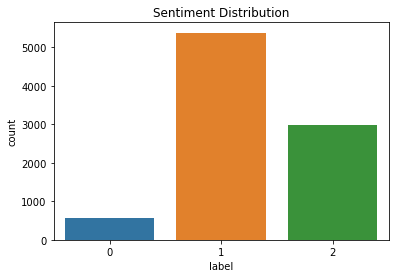

In [10]:
sns.countplot(data=tweets, x='label')
plt.title('Sentiment Distribution');


- The sentiment distribution above indicates that the dominant class was the `neutrals` followed by `positives` and relatively low `negatives`

- This is a clear indication of **class imbalance**

## 7. Data Modelling

### 7.1. Methodology
- For our baseline model, we will:

    - Apply `SMOTE` (with minority sampling) in our pipeline given class imbalance

    - Use `CountVectorizer` at first, since we are dealing with very short texts ('tweets') and term frequency might carry enough signal

    - Apply `RandomForestClassifier` because:
        - it has stronger out-of-the-box performance with zero hyperparameter tuning

        - It responds better to `SMOTE` and is less sensitive to class imbalance

### 7.2. Model Training and Evaluation

- We define a function that helps us to evaluate our models

In [11]:
# Define a Performance Evaluation Function

results = []

def evaluate_model(name, y_true, y_pred, results=[]):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy score': round(acc * 100, 2),
        'Weighted F1 score': round(f1_weighted * 100, 2)
    })
    return results

In [12]:
# Split the data into features and labels
X = tweets['document']
y = tweets['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a baseline model using CountVectorizer and RandomForestClassifier
baseline_model = Pipeline([
    ('vect', CountVectorizer()),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5))
])

# Fit the model on the training data
baseline_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = baseline_model.predict(X_test)

# Print Evaluation Scores
evaluate_model('Baseline (Original)', y_test, y_pred, results)
print(pd.DataFrame(results))

# Print cross-validated scores
cv_accuracy = np.mean(cross_val_score(baseline_model, X_train, y_train, cv=5))
print(f"Cross-validated Model Accuracy: {cv_accuracy:.2%}")

# Predict probabilities for ROC AUC
y_proba = baseline_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC_AUC Score (Multiclass): {roc_auc:.2%}")


                 Model  Accuracy score  Weighted F1 score
0  Baseline (Original)           40.49              38.42
Cross-validated Model Accuracy: 40.88%
ROC_AUC Score (Multiclass): 65.38%


In [24]:
# # Plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_model.classes_);

**Results Summary**
- Test Accuracy: **40.49%**
    - The model got about 40% of the new, unseen data correct. This is slightly better than chance (*33%*) for a **3-class problem** and indicates poor predictive performance.
- Cross-validated Accuracy: **40.88%**
    - This checks the model's consistency. Confirms a low risk of overfitting in the data but still shows underfitting (the model is not learning enough)
- Weighted F1 Score: **38.42%**
    - Slightly lower than but more reliable than accuracy given class imbalance. The model is still struggling on minority classes.
- ROC-AUC Score: **65.38%**
    - The model correctly separates classes 65% of the time but fails to translate this into accurate class predictions.



### Finetuning our Baseline Model
- In order to fine-tune our base model, we will:

    - Use `TF-IDF` as a vectorizer to see if there is an improvement in performance through a stronger signal

    - Incorporate `product_category` feature using `OneHotEncoder`

    - Employ `GridsearchCV` to fine-tune the hyperparameters for our model

- We will also employ other techniques for comparison such as:

    -  *Ensemble methods*: `XGBClassifier`

    - *Naive Bayes Classifiers*: `Multinomial Bayes`,`Complement Naive Bayes`

In [14]:
X = tweets[['document','product_category']]
y = tweets['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [15]:
from scipy.sparse import hstack

# Preprocess TRAIN data
tfidf = TfidfVectorizer().fit(X_train['document']) #TF-IDF
ohe = OneHotEncoder(handle_unknown='ignore').fit(X_train[['product_category']])#OneHotEncoder

X_train_tfidf = tfidf.transform(X_train['document'])
X_train_ohe = ohe.transform(X_train[['product_category']]) 
X_train_processed = hstack([X_train_tfidf, X_train_ohe])

# Preprocess TEST data
X_test_tfidf = tfidf.transform(X_test['document'])
X_test_ohe = ohe.transform(X_test[['product_category']])
X_test_processed = hstack([X_test_tfidf, X_test_ohe])

# Update pipeline 
baseline_model = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])

baseline_model.fit(X_train_processed, y_train)
baseline_preds = baseline_model.predict(X_test_processed)
evaluate_model('Baseline (New)', y_test, baseline_preds, results)

results_df = pd.DataFrame(results)
print(results_df)

# Print cross-validated scores
cv_accuracy = np.mean(cross_val_score(baseline_model, X_train_processed, y_train, cv=5))
print(f"Cross-validated Model Accuracy: {cv_accuracy:.2%}")

# Predict probabilities for ROC AUC
y_proba = baseline_model.predict_proba(X_test_processed)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC_AUC Score (Multiclass): {roc_auc:.2%}")

                 Model  Accuracy score  Weighted F1 score
0  Baseline (Original)           40.49              38.42
1       Baseline (New)           55.09              45.53
Cross-validated Model Accuracy: 55.63%
ROC_AUC Score (Multiclass): 68.19%


**Results Summary (Post-adjustments)**
- Test Accuracy: **55%**
    - Jump in accuracy (*14%*) confirms performance improvement. This is because of better feature weighting (using `TF-IDF`) and more features added(`product_category`)
- Cross-validated Accuracy: **55%**
    - Confirms that the model performance can be generalized to the test set.
- Weighted F1 Score: **45%**
    - *7%* increase suggests model is doing a better job with predicting minority classes, not just majority-class.
- ROC-AUC Score: **68%**
    - *3%* Increase suggests the model is even better at class separation. 



### HyperParameter Tuning Using `GridsearchCV`
#### Tuning `RandomForestClassifier`

- We are going to do the following below:
    - Creating a Pipeline using still using `SMOTE` to balance class distribution and `RandomForestClassifier` as our model

    - Setting up GridSearchCV which tries different combinations of hyperparameters, including:
    
        - `n_estimators`: Number of trees in the forest.
        - `max_depth`: How deep each tree can grow.
        - `min_samples_split`: Minimum samples to split a node.
        - `class_weight`: Whether to give more weight to minority class.

- The model runs 5-fold cross-validation to find the best parameters and uses `weighted_f1` as the scoring method

In [16]:
# RandomForestClassifier using GridSearchCV
pipe = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    pipe, 
    param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train_processed, y_train)
tuned_rf = grid_search.predict(X_test_processed)
evaluate_model('Tuned RF (GridSearch)', y_test, tuned_rf, results)

results_df = pd.DataFrame(results)
print(results_df)

# Print cross-validated scores
cv_accuracy = np.mean(cross_val_score(grid_search, X_train_processed, y_train, cv=5))
print(f"Cross-validated Model Accuracy: {cv_accuracy:.2%}")

# Predict probabilities for ROC AUC
y_proba = grid_search.predict_proba(X_test_processed)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC_AUC Score (Multiclass): {roc_auc:.2%}")


                   Model  Accuracy score  Weighted F1 score
0    Baseline (Original)           40.49              38.42
1         Baseline (New)           55.09              45.53
2  Tuned RF (GridSearch)           68.19              66.94
Cross-validated Model Accuracy: 66.66%
ROC_AUC Score (Multiclass): 78.53%


**Results Summary (Post-GridSearch)**
- Test Accuracy: **68.19%**
    - 
- Cross-validated Accuracy: **66.66%**
    - 
- Weighted F1 Score: **66.94%**
    - 
- ROC-AUC Score: **78.53%**
    -  

### Top 20 Most Important Features in Our RandomForest Classifier

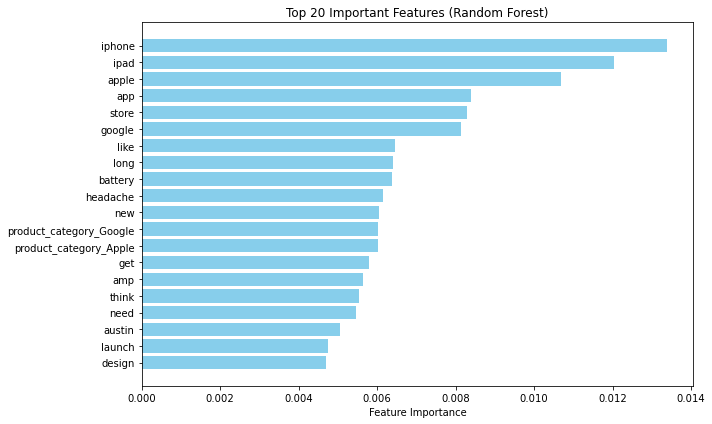

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get the best estimator (RandomForestClassifier) from the pipeline
best_rf = grid_search.best_estimator_.named_steps['clf']

# Get feature names from TF-IDF
tfidf_feature_names = tfidf.get_feature_names()

# Get feature names from OneHotEncoder
ohe_feature_names = ohe.get_feature_names(['product_category'])

# Combine all feature names
all_feature_names = np.concatenate([tfidf_feature_names, ohe_feature_names])

# Get feature importances from the best Random Forest model
importances = best_rf.feature_importances_

# Sort features by importance (top 20 for visualization)
indices = np.argsort(importances)[-20:]  # top 20 important features
top_features = all_feature_names[indices]
top_importances = importances[indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features (Random Forest)")
plt.tight_layout()
plt.show()


What “Feature Importance” Means:
- In a Random Forest, feature importance tells you:

    - “How much did this feature help the model reduce uncertainty (impurity) across all trees?”

    - A higher importance means that the feature was:

        - Frequently used in tree splits

        - Helped the model distinguish between classes

#### Alternative techniques: Ensemble models (`XGBClassifier`)

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

# Convert to dense format
X_train_dense = X_train_processed.toarray()
X_test_dense = X_test_processed.toarray()

# Pipeline without SMOTE
xgb_pipe_nosmote = Pipeline([
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

xgb_pipe_nosmote.fit(X_train_dense, y_train)
xgb_preds_nosmote = xgb_pipe_nosmote.predict(X_test_dense)
evaluate_model('XGBClassifier (no SMOTE)', y_test, xgb_preds_nosmote, results)

# Pipeline with SMOTE
xgb_pipe = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

xgb_pipe.fit(X_train_dense, y_train)
xgb_preds = xgb_pipe.predict(X_test_dense)
evaluate_model('XGBClassifier (SMOTE)', y_test, xgb_preds, results)

# Print results
results_df = pd.DataFrame(results)
print(results_df)

# Cross-validated scores
cv_accuracy_nosmote = np.mean(cross_val_score(xgb_pipe_nosmote, X_train_dense, y_train, cv=5))
print(f"Cross-validated Model Accuracy (No SMOTE): {cv_accuracy_nosmote:.2%}")

cv_accuracy_smote = np.mean(cross_val_score(xgb_pipe, X_train_dense, y_train, cv=5))
print(f"Cross-validated Model Accuracy (With SMOTE): {cv_accuracy_smote:.2%}")

# ROC AUC Scores
y_proba_nosmote = xgb_pipe_nosmote.predict_proba(X_test_dense)
roc_auc_nosmote = roc_auc_score(y_test, y_proba_nosmote, multi_class='ovr')
print(f"ROC_AUC Score (No SMOTE): {roc_auc_nosmote:.2%}")

y_proba_smote = xgb_pipe.predict_proba(X_test_dense)
roc_auc_smote = roc_auc_score(y_test, y_proba_smote, multi_class='ovr')
print(f"ROC_AUC Score (With SMOTE): {roc_auc_smote:.2%}")


[05:43:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:45:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


                      Model  Accuracy score  Weighted F1 score
0       Baseline (Original)           40.49              38.42
1            Baseline (New)           55.09              45.53
2     Tuned RF (GridS

 ### Key Takeaways

Tuned Random Forest provides the best balance of accuracy and F1 score, making it ideal for deployment in business settings.

XGBoost delivers the highest accuracy but may need threshold tuning to balance precision and recall.

Complement Naive Bayes yields a high F1 score, suggesting it's effective in capturing the minority class, but may misclassify more overall.

SMOTE generally improves the F1 Score across models, confirming that addressing class imbalance enhances minority sentiment detection.

#### Alternative techniques: Naive Bayes Classifiers (`MultinomialNB` and `ComplementNB`) 

In [20]:
# Multinomial Bayes
from sklearn.naive_bayes import MultinomialNB

mnb_pipe = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('clf',MultinomialNB())
])

mnb_pipe.fit(X_train_processed_csr, y_train)
mnb_preds = mnb_pipe.predict(X_test_processed_csr)
evaluate_model('Multinomial Bayes', y_test, mnb_preds, results)


# Complement Naive Bayes
from sklearn.naive_bayes import ComplementNB

complement_nb_pipe = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('clf', ComplementNB())
])

complement_nb_pipe.fit(X_train_processed_csr, y_train)
complement_nb_preds = complement_nb_pipe.predict(X_test_processed_csr)
evaluate_model('Complement Naive Bayes', y_test, complement_nb_preds, results)
  
results_df = pd.DataFrame(results)
print(results_df)

# Print cross-validated scores
cv_accuracy_MNB = np.mean(cross_val_score(mnb_pipe, X_train_processed, y_train, cv=5))
print(f"Cross-validated Model Accuracy (Multinomial): {cv_accuracy:.2%}")

cv_accuracy_smote = np.mean(cross_val_score(xgb_pipe, X_train_processed, y_train, cv=5))
print(f"Cross-validated Model Accuracy (Complement ): {cv_accuracy_smote:.2%}")

# Predict probabilities for ROC AUC
y_proba_mnb = mnb_pipe.predict_proba(X_test_processed)
roc_auc_mnb = roc_auc_score(y_test, y_proba_mnb, multi_class='ovr')
print(f"ROC_AUC Score (Multinomial): {roc_auc_mnb:.2%}")

y_proba_comp = complement_nb_pipe.predict_proba(X_test_processed)
roc_auc_comp = roc_auc_score(y_test, y_proba_comp, multi_class='ovr')
print(f"ROC_AUC Score (Complement): {roc_auc_comp:.2%}")

                      Model  Accuracy score  Weighted F1 score
0       Baseline (Original)           40.49              38.42
1            Baseline (New)           55.09              45.53
2     Tuned RF (GridSearch)           68.19              66.94
3  XGBClassifier (no SMOTE)           68.42              65.76
4     XGBClassifier (SMOTE)           67.74              65.19
5  XGBClassifier (no SMOTE)           68.60              65.84
6     XGBClassifier (SMOTE)           67.34              65.01
7         Multinomial Bayes           60.03              57.57
8    Complement Naive Bayes           62.23              63.51
Cross-validated Model Accuracy (Multinomial): 66.66%
[06:45:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

**Overall Results Summary**
- Best Overall Accuracy:
    - *XGBClassifier (SMOTE)* leads with a cross-validated score of 67.06% , meaning it predicts correctly more often than the others.

- Best Balance (F1 Score):
    - *XGBClassifier (no SMOTE)* has the highest F1 score (64.68%), meaning it’s better at treating all classes fairly, especially useful if you care about minority class detection.

- Best Class Predictions (ROC_AUC score):
    - *XGBClassifier (SMOTE)* has the highest ROC_AUC score (76.64%), implying it has the best performance when ranking true class probabilities

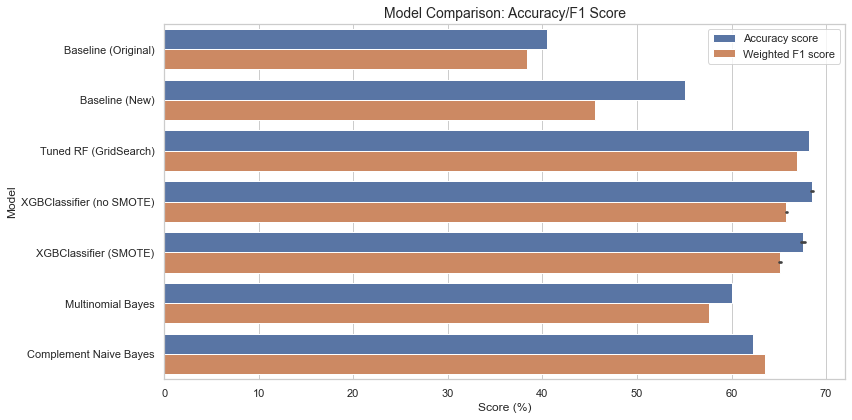

In [22]:
# Plot Results
# Set style
sns.set(style="whitegrid")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), 
            x="Score", y="Model", hue="Metric", ax=ax)

ax.set_title("Model Comparison: Accuracy/F1 Score", fontsize=14)
ax.set_xlabel("Score (%)")
ax.set_ylabel("Model")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show();


## 8. Conclusions and Recommendations

Based on the sentiment analysis pipeline and model evaluation, the following recommendations are proposed to help the business make data-driven decisions:

 1. **Proactive Sentiment Monitoring**
    - Deploy the best-performing model (e.g., Complement Naive Bayes or Tuned RandomForest Classifier) as a real-time sentiment engine to detect rising negative sentiment on social media.


 2. **Targeted Product Feedback Analysis**
    - Use the model to generate weekly or monthly reports showing sentiment broken down by `product_category`. Focus improvement efforts on products with a high percentage of negative sentiment.

 3. **Customer Support Optimization**
    - Create a feedback loop between the sentiment model and support operations:
        - Automatically flag tweets with strongly negative tone.
        - Route them to priority queues or initiate direct outreach.